# DSCI 100 Final Project

# Introduction

Dataset 1: players.csv

- A total of 196 observations were collected.
- Each observation contains 9 variables.
  
|Variable name  |Variable type|     Meaning          | 
|:--------------|:-----------|:----------------------|
|Experience     |factor      |Contains 5 elements: Beginner, Amateur, Regular, Pro, and Veteran; indicating the experience level of the minecraft player in the order from least to most experienced|
|subscribe      |logical     |Either TRUE, meaning the player agreed to subscribe their email, or the other way around which represented by FALSE|
|hashedEmail    |character   |The email of each of the player that is being encrypted| 
|played_hours   |double      |The hours each players played, range from 0-223.1 hours|
|name           |character   |The name of each players|
|gender         |factor      |The players identified themselves as female, male, non-binary, two-spirit, prefer not to say, other, or agender| 
|age            |integer     |The age of the players range from 8-99 years old|    
|individual ID  | -          |Used to identify each player in the game|
|organizationName| -         |The name of the organization each player belongs to|

# Methods & Results

# add methods and results here - pls edit

KNN regression was used to predict the total number of played hours predicted using 


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
set.seed(1)

url_players <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"

players <- read_csv(url_players)


Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
players_select <- players|> 
          select(experience, age, played_hours)

In [4]:
# to make the exprience into ordinal data 
players_numerical <- players_select|>
                     mutate(experience_num = case_when(experience == "Veteran" ~ 5,
                                                       experience == "Pro" ~ 4,
                                                       experience == "Regular" ~ 3,
                                                       experience == "Amateur" ~ 2,
                                                       experience == "Beginner" ~ 1))|>
                    select(-experience)

# add analysis here - pls edit

In [5]:
#spilting 
players_split <- initial_split(players_numerical, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

# add analysis here - pls edit

Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


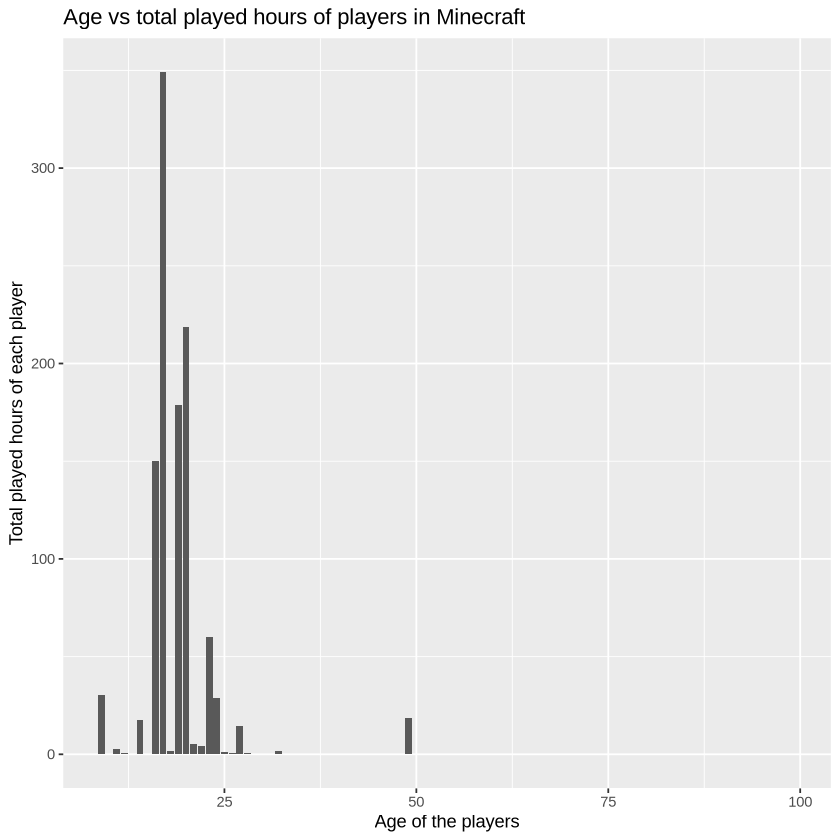

In [23]:
# exploratory plot of age vs played hours 
age_training_plot <- players_training|> 
                     ggplot(aes(x=age, 
                                y=played_hours))+
                     geom_histogram(stat = "identity")+
                     labs(x = "Age of the players",
                          y = "Total played hours of each player")+
                     ggtitle("Age vs total played hours of players in Minecraft")
age_training_plot 

# add analysis here -pls edit

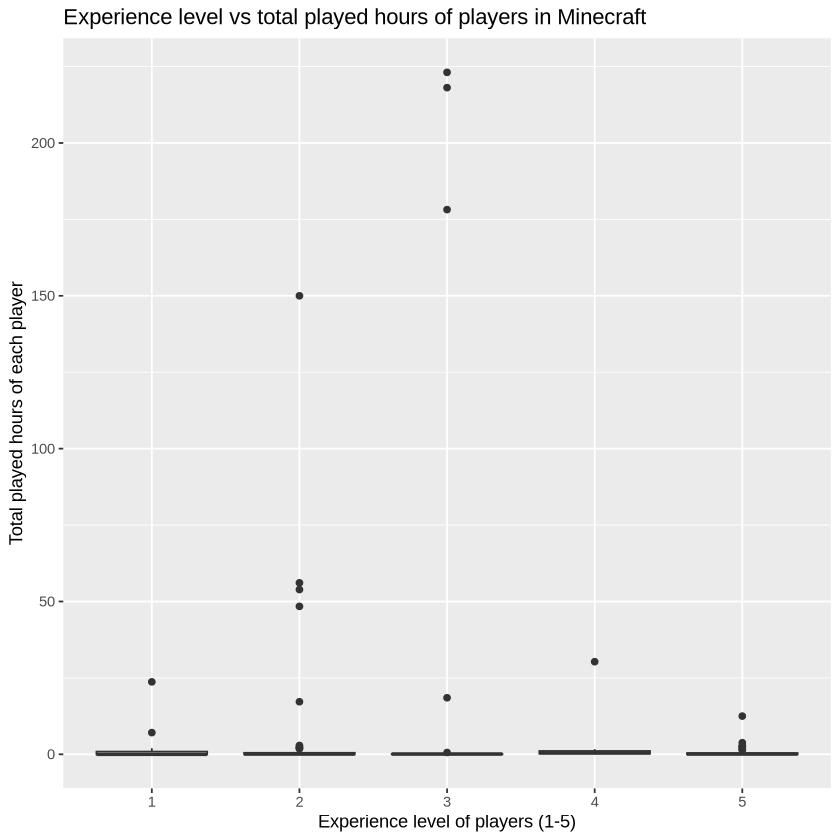

In [25]:
# exploratory plot of experience level vs played hours 
experience_training_plot <- players_training|> 
                            ggplot(aes(x=as.factor(experience_num), 
                                       y=played_hours))+
                            geom_boxplot()+
                            labs(x = "Experience level of players (1-5)",
                                 y = "Total played hours of each player")+
                            ggtitle("Experience level vs total played hours of players in Minecraft")
experience_training_plot 


# add analysis here  - pls edit

Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


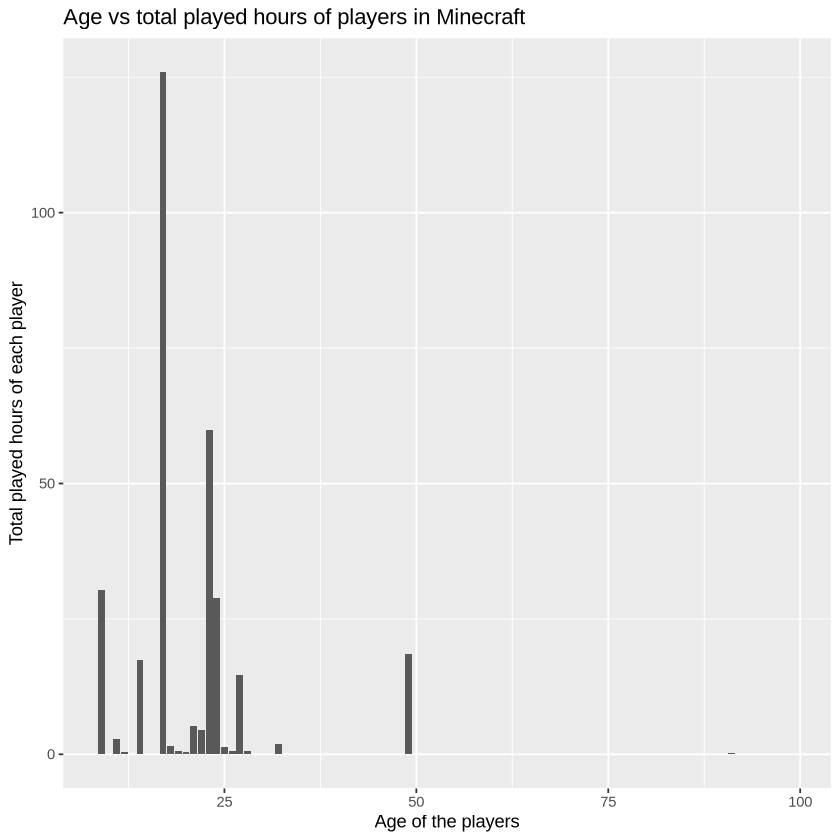

In [29]:
# removed outliers 

players_training_clean <- players_training|> 
                          filter(played_hours < 150)

age_training_plot <- players_training_clean|> 
                     ggplot(aes(x=age, 
                                y=played_hours))+
                     geom_histogram(stat = "identity")+
                     labs(x = "Age of the players",
                          y = "Total played hours of each player")+
                     ggtitle("Age vs total played hours of players in Minecraft")
age_training_plot 

In [8]:
# receipe for the knn regression

players_recipe <- recipe(played_hours ~ experience_num + age, data = players_training) |>
                   step_scale(all_predictors()) |>
                   step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", 
                                 neighbors = tune()) |> 
                set_engine("kknn") |>
                set_mode("regression") 

# add analysis here - pls edit

In [9]:
# cross - validation using 5 folds
players_vfold <- vfold_cv(data = players_training, v = 5, strata = played_hours)

players_workflow <- workflow() |>
                     add_recipe(players_recipe) |>
                     add_model(players_spec)


# add analysis here - pls edit

In [10]:
# testing to see which k neighbours would be best based on lowest rmse

gridvals <- tibble(neighbors = seq(from = 1, to = 85, by = 5))

players_results_min <- players_workflow |>
                       tune_grid(resamples = players_vfold, grid = gridvals)|> 
                       collect_metrics()|> 
                       filter(.metric == "rmse")|>
                       filter(mean == min(mean))
head(players_results_min)


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
36,rmse,standard,28.36686,5,7.262733,Preprocessor1_Model08


# add analysis here - pls edit

In [11]:
# testing with test data and find rmse

k_min <- players_results_min |>
         pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
                     set_engine("kknn") |>
                     set_mode("regression")

players_fit <- workflow() |>
               add_recipe(players_recipe) |>
               add_model(players_best_spec) |>
               fit(data = players_training)


players_summary <- players_fit |>
                   predict(players_testing) |>
                   bind_cols(players_testing) |>
                   metrics(truth = played_hours, estimate = .pred)|>
                   filter(.metric == "rmse")
players_summary


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,10.4067


# add analysis here - pls edit

.pred,age,played_hours,experience_num
<dbl>,<dbl>,<dbl>,<dbl>
0.4861111,17,0.0,5
18.9083333,21,0.1,3
7.7944444,17,0.1,2
0.8444444,22,0.0,5
0.4861111,17,0.0,5
2.4305556,17,0.0,1


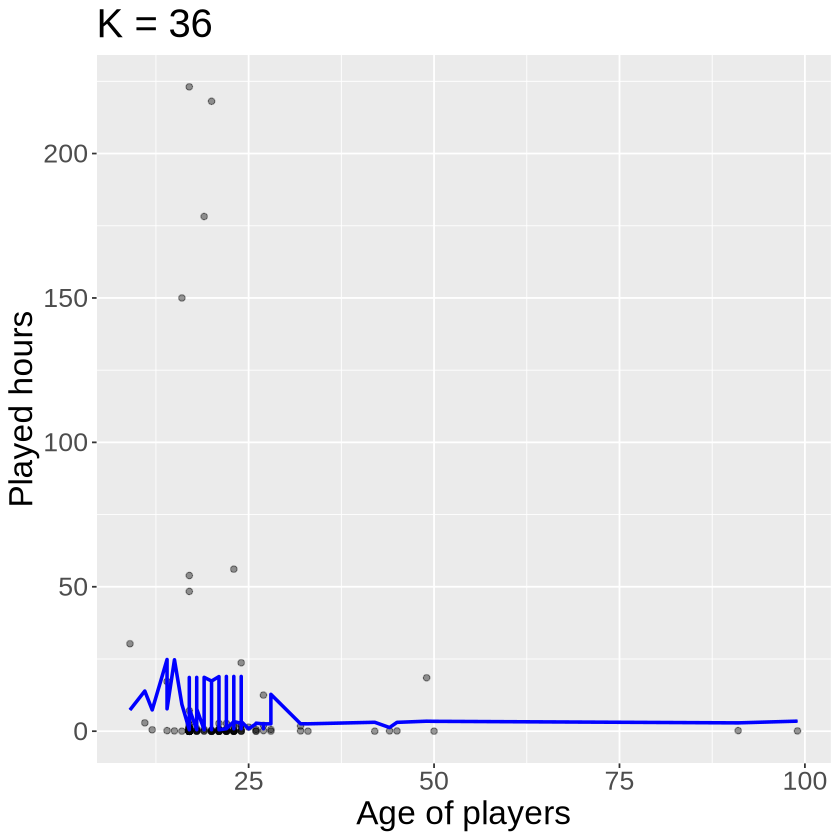

In [13]:
# visualizing the relationship between age and played hours with k = 36

players_preds <- players_fit |>
                 predict(players_training) |>
                 bind_cols(players_training)

head(players_preds)

players_plot <- ggplot(players_preds, aes(x = age, y = played_hours)) +
                geom_point(alpha = 0.4) +
                geom_line(data = players_preds,
                          mapping = aes(x = age, y = .pred),
                          color = "blue",
                          linewidth = 1) +
                xlab("Age of players") +
                ylab("Played hours") + 
                geom_line(data = players_preds, aes(x = age, y = .pred), color = "blue") +
                ggtitle(paste0("K = ", k_min)) +
                theme(text = element_text(size = 20))

players_plot

# add analysis here - pls edit

.pred,age,played_hours,experience_num
<dbl>,<dbl>,<dbl>,<dbl>
0.4861111,17,0.0,5
18.9083333,21,0.1,3
7.7944444,17,0.1,2
0.8444444,22,0.0,5
0.4861111,17,0.0,5
2.4305556,17,0.0,1


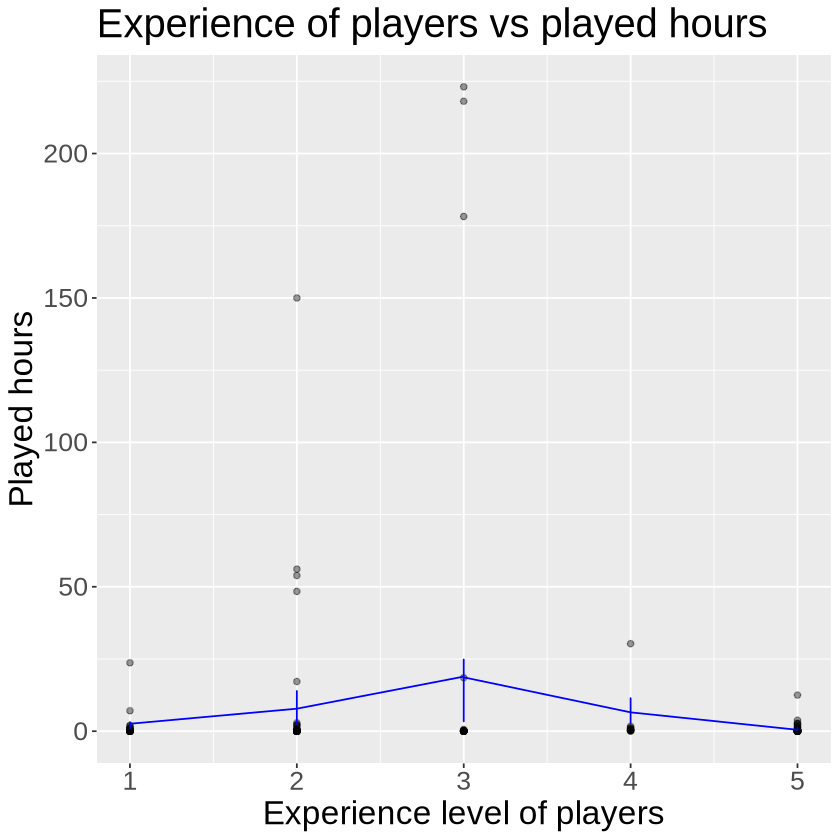

In [17]:
# visualizing the relationship between age and played hours  --> delete your help
players_preds <- players_fit |>
                predict(players_training) |>
                bind_cols(players_training)

head(players_preds)

players_plot <- ggplot(players_preds, aes(x = experience_num, y = played_hours)) +
                geom_point(alpha = 0.4) +
                xlab("Experience level of players") +
                ylab("Played hours") + 
                geom_line(data = players_preds, aes(x = experience_num, y = .pred), color = "blue") +
                ggtitle("Experience of players vs played hours") +
                theme(text = element_text(size = 20))

players_plot

# add anaylsis here - pls edit 